!pip install git+https://github.com/EEA-sensors/parallel-non-linear-gaussian-smoothers.git@master

If running on Colab please run the command above.

### Imports

In [1]:
import jax.numpy as jnp
from jax import jit
from jax import scipy
from jax.config import config

from parsmooth.kalman.parallel import ekf, eks, ieks
# from parsmooth.sequential import ekf as seq_ekf, eks as seq_eks, ieks as seq_ieks
from parsmooth.models.bearings import get_data, make_parameters, plot_bearings
from parsmooth.utils import MVNormalParameters

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

### Input parameters Bearings

In [2]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 1000  # number of observations

### Get parameters Bearings

In [3]:
Q, transition_function, observation_function, R = make_parameters(qc, qw, r, dt, s1, s2)


### Get data

In [4]:
ts, true_states, observations = get_data(x0, dt, r, T, s1, s2, random_state=42)

### We can now run the filter and smoother

Initial state guess

In [5]:
m = jnp.array([-1., -1., 0., 0., 0.])
P = jnp.eye(5)
N = scipy.linalg.cholesky(P, lower = True)

initial_guess = MVNormalParameters(m, N)

Run the filter

In [6]:
initial_states = MVNormalParameters(jnp.zeros((T, 5)), jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T, axis=0))

In [7]:
filtered, linear_param = ekf(initial_guess, 
                               observations, 
                               transition_function, 
                               Q, 
                               observation_function, 
                               R, 
                               initial_states.mean)

In [8]:
smoothed = eks(filtered,linear_param)

### And the iterated one

In [9]:
iterated_smoothed_trajectories = ieks(initial_guess, 
                                      observations, 
                                      transition_function, 
                                      Q, 
                                      observation_function, 
                                      R, 
                                      initial_states, 
                                      n_iter=100)

# Plot the result

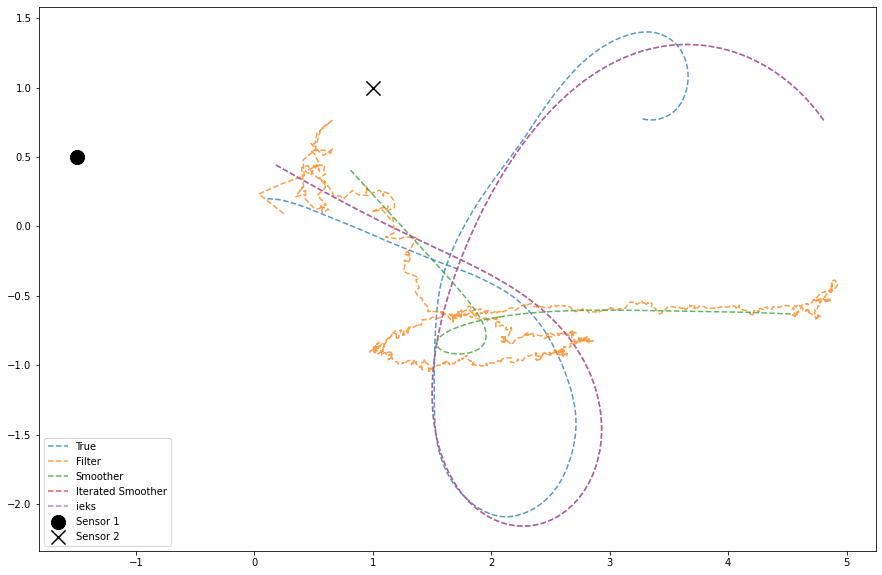

In [11]:
plot_bearings([true_states, filtered.mean, smoothed.mean, iterated_smoothed_trajectories.mean, iterated_smoothed_trajectories.mean], 
              ["True", "Filter", "Smoother", "Iterated Smoother","ieks"], 
              s1, s2, figsize=(15, 10), quiver=False)
